# Data Exploration
### Authors: Jack Duryea (jd50), Shashank Mahesh (sm103)

In [170]:
import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
from scipy import stats
import glob

%matplotlib inline

In [46]:
# TODO: create a class that encapsulates a lot of image and image metadata

current directory structure:

Data-Science-Bowl/ {   
        DataExploration.ipynb  
    Readme.md  
    stage1_sample_submission.csv  
    stage1_test/  
    stage1_train/  
    stage1_train/labels.csv 
    }
    

### Load image data

In [10]:
# Glob the training data and load a single image path
training_paths = pathlib.Path('stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[0]
im = imageio.imread(str(im_path))

### Let's check out a few example images

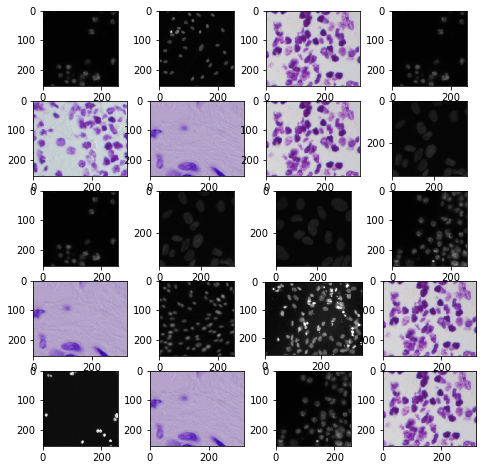

In [137]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    im_path = training_sorted[np.random.randint(i)]
    im = imageio.imread(str(im_path))
    fig.add_subplot(rows, columns, i)
    plt.imshow(im)
plt.show()

### Distribution of the number of nuclei in each image

In [35]:
outlier_images = []
nuclei_data = []
path, dirs, files = os.walk("stage1_train").next()
for case in dirs:
    p, d, masks = os.walk("stage1_train/"+case+"/masks").next()
    nuclei_count = len(masks)
    #print nuclei_count
    # outliers
    if nuclei_count > 200:
        outlier_im = imageio.imread("stage1_train/"+case+"/images/"+case+".png")
        outlier_images.append((outlier_im, nuclei_count))
    nuclei_data.append(nuclei_count)
nuclei_data = np.array(nuclei_data)

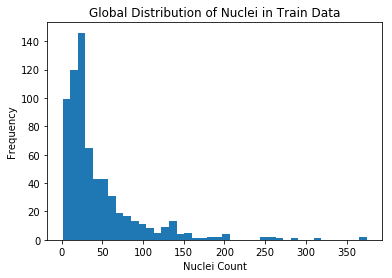

In [30]:
plt.xlabel("Nuclei Count")
plt.ylabel("Frequency")
plt.title("Global Distribution of Nuclei in Train Data")
plt.hist(nuclei_data, bins = 40);


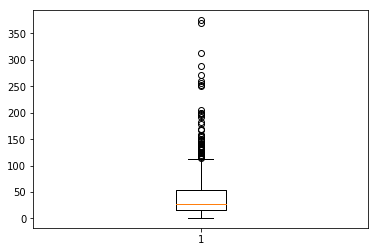

In [109]:
plt.boxplot(nuclei_data);

## Distribution statistics

In [38]:
stats.describe(nuclei_data)

DescribeResult(nobs=670, minmax=(1, 375), mean=43.971641791044775, variance=2300.4042768221675, skewness=2.865307317651728, kurtosis=11.325741184404169)

# Outlier images, images with lots of nuclei

Number of nuclei in below image:  206


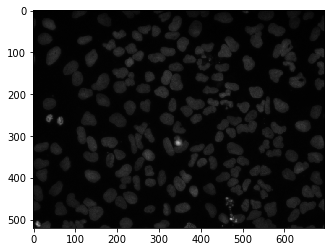

Number of nuclei in below image:  375


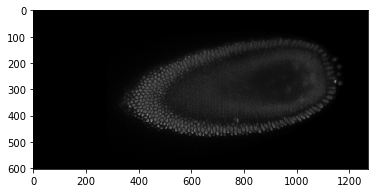

Number of nuclei in below image:  313


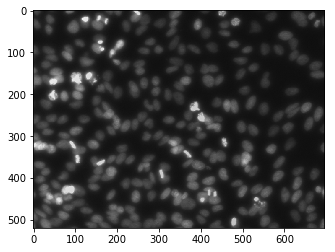

Number of nuclei in below image:  250


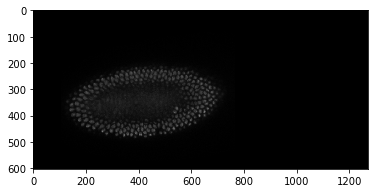

Number of nuclei in below image:  369


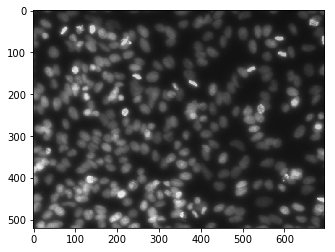

Number of nuclei in below image:  257


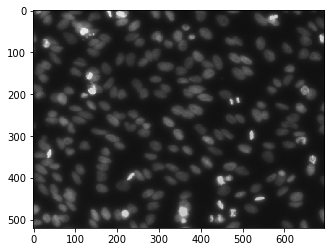

Number of nuclei in below image:  253


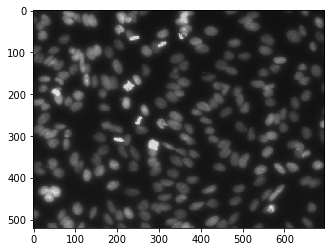

Number of nuclei in below image:  289


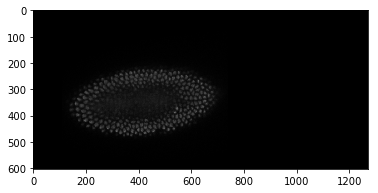

Number of nuclei in below image:  260


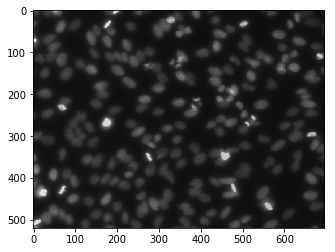

Number of nuclei in below image:  272


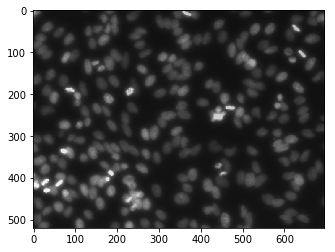

In [37]:
for im in outlier_images:
    plt.imshow(im[0]);
    print "Number of nuclei in below image: ", im[1]
    plt.show()

# Distribution of image sizes

In [45]:
image_size_data = [] # tuples of the form (width, height) 
for case in dirs:
    im = outlier_im = imageio.imread("stage1_train/"+case+"/images/"+case+".png")
    w = im.shape[0]
    h = im.shape[1]
    image_size_data.append([w,h])

In [49]:
widths = np.array([x[0] for x in image_size_data])
heights = np.array([x[1] for x in image_size_data])

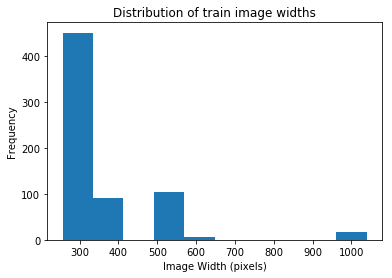

In [53]:
plt.xlabel("Image Width (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of train image widths")
plt.hist(widths);

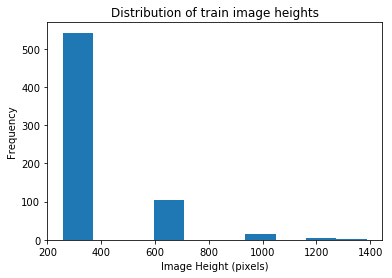

In [54]:
plt.xlabel("Image Height (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of train image heights")
plt.hist(heights);

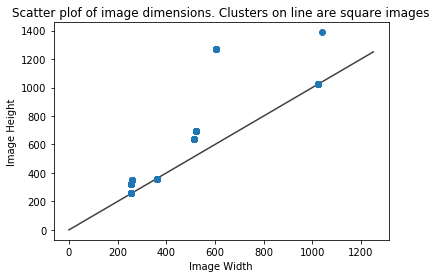

In [79]:
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Scatter plof of image dimensions. Clusters on line are square images")
plt.scatter(widths, heights);
plt.plot([0,1250],[0,1250], 'k-', alpha=0.75, zorder=0);


In [93]:
# Number of unique image dimensions

In [99]:
print "There are " + str(len(np.unique(image_size_data,axis=0))) + " unique image dimensions"

There are 9 unique image dimensions


In [106]:
print "Unique image dimensions"
sizes, counts = np.unique(image_size_data,axis=0, return_counts=True)
print sizes
print "Respective frequencies: " + str(counts)

Unique image dimensions
[[ 256  256]
 [ 256  320]
 [ 512  640]
 [1024 1024]
 [ 260  347]
 [ 520  696]
 [1040 1388]
 [ 603 1272]
 [ 360  360]]
Respective frequencies:[334 112  13  16   5  92   1   6  91]


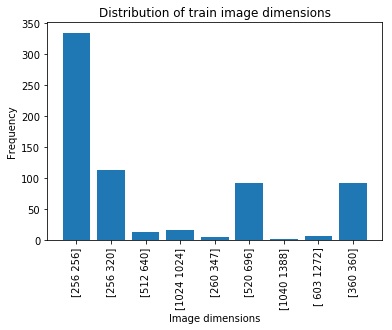

In [145]:
plt.xlabel("Image dimensions")
plt.ylabel("Frequency")
plt.title("Distribution of train image dimensions")
plt.bar(range(len(counts)), counts)
labels = [str(x) for x in np.unique(image_size_data,axis=0)]
plt.xticks(range(len(counts)),labels, rotation=90);

### Total number of pixels

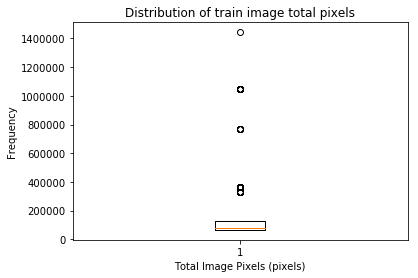

In [144]:
plt.xlabel("Total Image Pixels (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of train image total pixels")
plt.boxplot(widths*heights);

# Positions of nuclei in 256 x 256 images

In [255]:
ct = 0
imgs = []
x_coords = np.array([])
y_coords = np.array([])
for file_name in glob.iglob('stage1_train/*/masks/*'):
    ct += 1
    if ct == 10000:
        break
    imgs.append(result)
    im = imageio.imread(file_name)
    im = rgb2gray(im)
    if im.shape == (256,256):
        x = get_nuclei_pixels(im)[:,0]
        y = get_nuclei_pixels(im)[:,1]
        x_coords = np.append(x_coords,x)
        y_coords = np.append(y_coords,y)


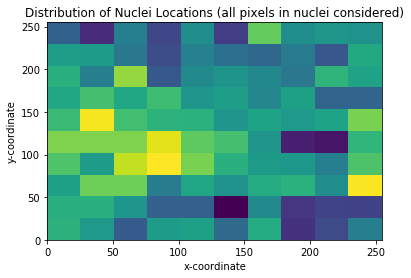

In [264]:
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Distribution of Nuclei Locations (all pixels in nuclei considered)")
plt.hist2d(x_coords, y_coords, bins=10);


### It seems that the pixels are uniformly distributed overall

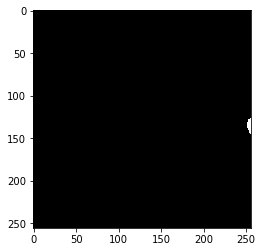

In [199]:
plt.imshow(im2,cmap='gray')

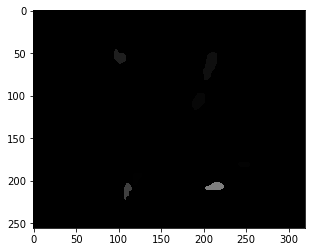

In [206]:
for r in imgs[:100]:
    im = imageio.imread(r)
    plt.imshow(im,cmap='gray',alpha=0.5)

In [228]:
# return the cooridnates 
def get_nuclei_pixels(image):
    return np.argwhere(image != 0)
    

In [271]:
a = np.array([[1,2],[3,4],[1,2],[4,5]])
np.unique(a,axis=0)

array([[1, 2],
       [3, 4],
       [4, 5]])

# Overlapping Nuclei?

In [310]:
b = np.array([[4,5],[6,6],[4,5]])
np.unique(b,axis=0)

array([[4, 5],
       [6, 6]])

In [306]:
print coords.shape

(0,)


In [327]:
ct = 0

overlap_data = []

for file_name in glob.iglob('stage1_train/*'):
    ct += 1
    if ct == 1000:
        break
    coords = np.zeros(shape=(1,2))
    for mask_name in glob.iglob(file_name + "/masks/*.png"):
        im = imageio.imread(mask_name)
        im = rgb2gray(im)
        if im.shape == (256,256):
            coords = np.append(coords, get_nuclei_pixels(im),axis=0)
    overlap_amount = len(coords)-len(np.unique(coords,axis=0))
    if overlap_amount > 0:
        print file_name
    overlap_data.append(overlap_amount)

stage1_train/5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856
stage1_train/358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556
stage1_train/8fdc34509a0c3721f7b5e235c8a93e1f553343aa17ad103a1e89e3509a3e1570
stage1_train/0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0
stage1_train/5b2ccfb94dedf2ec8797c0404fc324888e35ab903c41bb26f070552033ca8e6c
stage1_train/693bc64581275f04fc456da74f031d583733360a1f6032fa38b3fbf592ff4352
stage1_train/1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
stage1_train/ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee
stage1_train/7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2
stage1_train/b67a6e5da8b1cfa5319d94a7d3f8b706725753346c37a4636bf7382e98b3c5df
stage1_train/619429303c1af7540916509fe7900cf483eba4391b06aac87ff7f66ca1ab6483
stage1_train/75120baa6abcbfe750a4eb223b8c10ae6bc3bebdda7b00d9a78bc2472fa28625
stage1_train/f6863b83d75e5927b30e2e326405b588293283c25aaef2251b3

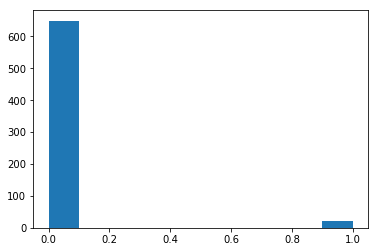

In [329]:
plt.hist(overlap_data);

In [54]:
training_paths = pathlib.Path('stage1_train').glob('*')
training_sorted = sorted([x for x in training_paths])

In [18]:
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (256, 256, 4)
New image shape: (256, 256)


In [55]:
path, dirs, files = os.walk("stage1_train").next()
im_count = len(dirs)

In [45]:
case0 = dirs[0]

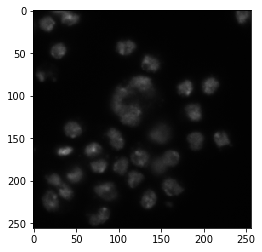

In [143]:
plt.imshow(outlier_im)

In [90]:
stats.kstest(nuclei_data, 'norm')

KstestResult(statistic=0.98820234077433999, pvalue=0.0)